# Oxford: Smooth fit to log-odds ratios

In [1]:
import tqdm 
import pprint

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

## Données

In [2]:
import json 

with open("data/data.json") as file:
    data = json.load(file)
    
with open("data/init.json") as file:
    init = json.load(file)
    
with open("data/params.json") as file:
    params = json.load(file)

In [3]:
for idx, item in data.items():
    data[idx] = np.array(item).reshape(-1)

for idx, item in init.items():
    init[idx] = np.array(item).reshape(-1)

for idx, item in params.items():
    params[idx] = np.array(item).reshape(-1)

In [4]:
data["year2"] = np.power(data["year"], 2) - 22
init["tau"] = init["sigma_sq"]
del init["sigma_sq"]

In [5]:
df = pd.DataFrame(data)

df["nr_sum_diff"] = df.n0 + df.n1 - df.r0 - df.r1
df["n1r1_diff"] = df.n1 - df.r1

In [6]:
params["tau_a"] = 1e-3
params["tau_b"] = 1e-3

params["var"] = 1e6

## Echantillonneur MCMC

In [7]:
def sampler(nchain, data, init, params):
    
    # initialisation de la chaîne
    # acceptance rates are stored in history
    chain = dict()
    history = dict()
    for param_name, param_init in init.items():
        chain[param_name] = np.zeros((nchain+1, param_init.shape[0]))
        chain[param_name][0, :] = param_init
        
        history[param_name] = np.zeros(param_init.shape[0])
        
    # définition des hyper-paramètres
    K = int(params["K"])
    
    tau_a = params["tau_a"]
    tau_b = params["tau_b"]
    tau_shape = tau_a + K/2
    
    var = params["var"]
    
    mu_sd_proposal = params["mu_sd_proposal"]
    alpha_sd_proposal = params["alpha_sd_proposal"]
    beta1_sd_proposal = params["beta1_sd_proposal"]
    beta2_sd_proposal = params["beta2_sd_proposal"]
    b_sd_proposal = params["b_sd_proposal"]
    
    rng = np.random.default_rng()
    for i in tqdm.tqdm(range(1, nchain+1)):
        ## mise à jour de mu 
        mu_current = chain["mu"][i-1, :]
        alpha_current = chain["alpha"][i-1, :]
        beta1_current = chain["beta1"][i-1, :]
        beta2_current = chain["beta2"][i-1, :]
        b_current = chain["b"][i-1, :]
        
        logpsi_current = alpha_current + beta1_current * data.year + beta2_current*data.year2 + b_current
    
        mu_proposal = mu_current + np.random.normal(scale=mu_sd_proposal, size=K)
        
        mu_top = - np.power(mu_proposal,2) / (2*var) - data.nr_sum_diff * mu_proposal
        mu_top = mu_top - data.n0 * np.log1p(np.exp(-mu_proposal))
        mu_top = mu_top - data.n1 * np.log1p(np.exp(-mu_proposal -logpsi_current))
        
        mu_bottom = - np.power(mu_current,2) / (2*var) - data.nr_sum_diff * mu_current
        mu_bottom = mu_bottom - data.n0 * np.log1p(np.exp(-mu_current))
        mu_bottom = mu_bottom - data.n1 * np.log1p(np.exp(-mu_current-logpsi_current))
        
        mu_acceptance = np.exp(mu_top - mu_bottom)
        
        mu_accept_mask = (mu_acceptance > np.random.rand(K))
        mu_current[mu_accept_mask] = mu_proposal[mu_accept_mask]
        
        history["mu"] =  history["mu"] + mu_accept_mask
        chain["mu"][i, :] = mu_current
        
        ## mise à jour de alpha
        alpha_proposal = alpha_current + np.random.normal(scale=alpha_sd_proposal)
        logpsi_proposal = logpsi_current + (alpha_proposal - alpha_current)
        
        alpha_top = - np.power(alpha_proposal, 2) / (2*var)
        alpha_top = alpha_top - np.sum(logpsi_proposal * data.n1r1_diff)
        alpha_top = alpha_top - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_proposal)))
        
        alpha_bottom = - np.power(alpha_current, 2) / (2*var) 
        alpha_bottom = alpha_bottom - np.sum(logpsi_current * data.n1r1_diff)
        alpha_bottom = alpha_bottom - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_current)))
        
        alpha_acceptance = np.exp(alpha_top - alpha_bottom)
        if alpha_acceptance > np.random.rand():
            chain["alpha"][i, :] = alpha_proposal
            alpha_current = alpha_proposal
            logpsi_current = logpsi_proposal
            history["alpha"] += 1
        else:
            chain["alpha"][i, :] = alpha_current
        
        ## mise à jour de beta1
        beta1_proposal = beta1_current + np.random.normal(scale=beta1_sd_proposal)
        logpsi_proposal = logpsi_current + (beta1_proposal - beta1_current)* data.year
        
        beta1_top = - np.power(beta1_proposal, 2) / (2*var)
        beta1_top = beta1_top - np.sum(logpsi_proposal * data.n1r1_diff)
        beta1_top = beta1_top - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_proposal)))
        
        beta1_bottom = - np.power(beta1_current, 2) / (2*var)
        beta1_bottom = beta1_bottom - np.sum(logpsi_current * data.n1r1_diff)
        beta1_bottom = beta1_bottom - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_current)))
        
        beta1_acceptance = np.exp(beta1_top - beta1_bottom)
        if beta1_acceptance > np.random.rand():
            chain["beta1"][i, :] = beta1_proposal
            beta1_current = beta1_proposal
            logpsi_current = logpsi_proposal
            history["beta1"] += 1
        else:
            chain["beta1"][i, :] = beta1_current
        
        ## mise à jour de beta2
        beta2_proposal = beta2_current + np.random.normal(scale=beta2_sd_proposal)
        logpsi_proposal = logpsi_current + (beta2_proposal - beta2_current) * data.year2
        
        beta2_top = - np.power(beta2_proposal, 2) / (2*var)
        beta2_top = beta2_top - np.sum(logpsi_proposal * data.n1r1_diff)
        beta2_top = beta2_top - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_proposal)))
        
        beta2_bottom = - np.power(beta2_current, 2) / (2*var)
        beta2_bottom = beta2_bottom - np.sum(logpsi_current * data.n1r1_diff)
        beta2_bottom = beta2_bottom - np.sum(data.n1 * np.log1p(np.exp(-mu_current-logpsi_current)))
        
        beta2_acceptance = np.exp(beta2_top - beta2_bottom)
        if beta2_acceptance > np.random.rand():
            chain["beta2"][i, :] = beta2_proposal
            beta2_current = beta2_proposal
            logpsi_current = logpsi_proposal
            history["beta2"] += 1
        else:
            chain["beta2"][i, :] = beta2_current
        
        
        ## mise à jour de tau
        tau_proposal = rng.gamma(tau_shape, scale=1/(tau_b+.5*np.sum(np.power(b_current,2))))
        chain["tau"][i, :] = tau_proposal
        history["tau"] += 1
        
        tau_current = tau_proposal
        
        ## mise à jour de b
        b_proposal = b_current + np.random.normal(scale=b_sd_proposal, size=K)
        logpsi_proposal = logpsi_current + (b_proposal - b_current)
        
        b_top = - (tau_current / 2) * np.power(b_proposal, 2)
        b_top = b_top - logpsi_proposal * data.n1r1_diff
        b_top = b_top - data.n1 * np.log1p(np.exp(-mu_current-logpsi_proposal))
        
        b_bottom = - (tau_current / 2) * np.power(b_current, 2)
        b_bottom = b_bottom - logpsi_current * data.n1r1_diff
        b_bottom = b_bottom - data.n1 * np.log1p(np.exp(-mu_current-logpsi_current))
        
        b_acceptance = np.exp(b_top - b_bottom)
        b_accept_mask = (b_acceptance > np.random.rand(K))
        b_current[b_accept_mask] = b_proposal[b_accept_mask]
        logpsi_current[b_accept_mask] = logpsi_proposal[b_accept_mask]
        
        history["b"] = history["b"] + b_accept_mask
        chain["b"][i, :] = b_current
        
    for param_name, param_history in history.items():
        history[param_name] = param_history / nchain
    
    return chain, history

### Choix des écart-types pour M.-H.

In [8]:
sd_proposal_grid = [
    # la liste est à modifier pour trouver les bonnes valeurs
    (3.0, 0.16, 0.05, 0.008, 1.0),
]

for u in sd_proposal_grid:
    params["mu_sd_proposal"] = u[0]
    params["alpha_sd_proposal"] = u[1]
    params["beta1_sd_proposal"] = u[2]
    params["beta2_sd_proposal"] = u[3]
    params["b_sd_proposal"] = u[4]
    
    _, history = sampler(1000, df, init, params )
    pprint.pprint(history)
    pprint.pprint(u)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.30it/s]

{'alpha': array([0.277]),
 'b': 0      0.007
1      0.012
2      0.016
3      0.007
4      0.011
       ...  
115    0.016
116    0.013
117    0.014
118    0.012
119    0.013
Length: 120, dtype: float64,
 'beta1': array([0.213]),
 'beta2': array([0.27]),
 'mu': 0      0.247
1      0.171
2      0.211
3      0.142
4      0.148
       ...  
115    0.182
116    0.137
117    0.131
118    0.177
119    0.169
Length: 120, dtype: float64,
 'tau': array([1.])}
(3.0, 0.16, 0.05, 0.008, 1.0)


### Génération de la chaîne

In [9]:
params["mu_sd_proposal"]  = 2.5
params["alpha_sd_proposal"] = .16
params["beta1_sd_proposal"] = .05
params["beta2_sd_proposal"] = .008
params["b_sd_proposal"] = .2

chain, history = sampler(20000, df, init, params)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:25<00:00, 97.34it/s]


In [10]:
for param_name, param_rate in history.items():
    print(f"Taux d'acceptation pour {param_name}: \n{param_rate}")

Taux d'acceptation pour alpha: 
[0.26965]
Taux d'acceptation pour beta1: 
[0.2216]
Taux d'acceptation pour beta2: 
[0.2567]
Taux d'acceptation pour mu: 
0      0.30075
1      0.21795
2      0.25705
3      0.18920
4      0.18005
        ...   
115    0.19565
116    0.16330
117    0.16225
118    0.20155
119    0.19640
Length: 120, dtype: float64
Taux d'acceptation pour b: 
0      0.43990
1      0.44355
2      0.43905
3      0.43510
4      0.43645
        ...   
115    0.43710
116    0.43195
117    0.43290
118    0.44710
119    0.43960
Length: 120, dtype: float64
Taux d'acceptation pour tau: 
[1.]


### Visualisation des chaînes

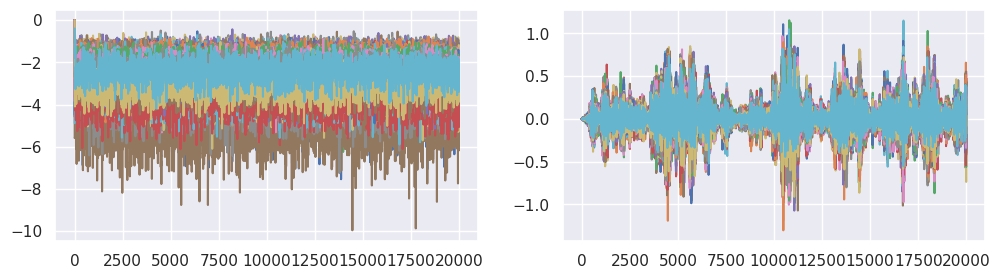

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12,3))
axs[0].plot(chain["mu"])
axs[1].plot(chain["b"])
plt.show()

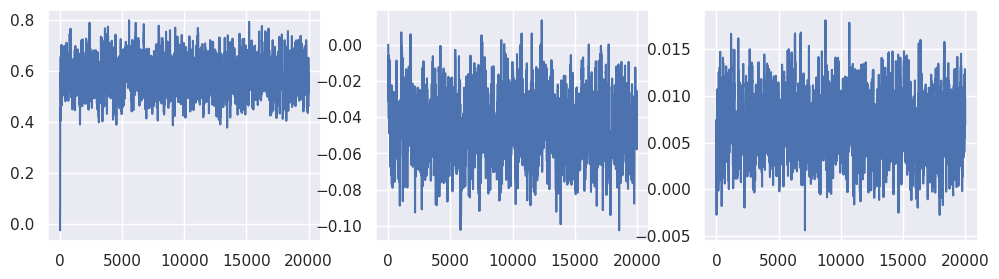

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(chain["alpha"])
axs[1].plot(chain["beta1"])
axs[2].plot(chain["beta2"])
plt.show()

## Lois conditionnelles pleines

### Visualisation

In [15]:
samples = dict()
for param_name, param_chain in chain.items():
    samples[param_name] = chain[param_name][500:]

samples["sigma"] = 1/np.sqrt(samples["tau"])

del samples["tau"]
del samples["mu"]
del samples["b"]

for param_name, param_chain in samples.items():
    samples[param_name] = samples[param_name].reshape(-1)

samples = pd.DataFrame(samples)

In [16]:
plt.clf()
for param_name in samples.columns:
    samples[param_name].plot(rot=30);
    plt.savefig(f"report/images/chain_{param_name}.png")
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [17]:
plt.clf()
for param_name in samples.columns:
    g = sns.displot(samples[param_name], legend=False, kind="kde")
    g.set_axis_labels( "", "Densité")
    plt.savefig(f"report/images/density_{param_name}.png")
    plt.clf()

<Figure size 640x480 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

### Estimation ponctuelle

In [18]:
for param_name, param_sample in samples.items():
    print(("Estimation du paramètre {}\t: {:.3} "+u"\u00B1"+" {:.3}").format(param_name, np.mean(param_sample),np.std(param_sample)))

Estimation du paramètre alpha	: 0.581 ± 0.0618
Estimation du paramètre beta1	: -0.0452 ± 0.0159
Estimation du paramètre beta2	: 0.00689 ± 0.00298
Estimation du paramètre sigma	: 0.101 ± 0.0631
